# Discovering Predictive Biological Networks

**Tl:Dr** A common biological assumption when dealing with high dimensional covariates is that a network of correlated covariates is responsible for the phenotype of interest. This naturally suggests latent variable models as a means to uncover these networks. Unfortunately, these models perform poorly in practice, which often leads them to be discarded as a feasible approach. We developed a novel inference algorithm that allows us to maintain predictive performance with generative models, combining the best of predictive and generative modeling. We demonstrate this method by discovering a predictive network of stress in mice based on electrophysiological recordings.

# Load in imports 

In [3]:
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score,roc_curve

import matplotlib.pyplot as plt

import pandas as pd
import torch

from bystro.supervised_ppca.gf_dropout_pt import PPCADropout

## Application: Neuroscience

While we are in the genetics business, it's difficult to have an intuition of genes like ERBB2, MET, MYC, etc to evaluate whether the networks we uncover are reasonable. Instead, we will use a neuroscience application to demonstrate our ability to discover predictive networks. This data comes from 26 mice implanted with electrodes in 11 different brain regions. These mice are then placed in stressful and not stressful conditions while recording the voltages in these 11 regions (LFPs). 

Previous work has shown that spectral information in these LFPs is highly relevant biologically. We divide the recordings into 1-second windows and extract spectral power from 1 to 56 hertz in each region. This allows us to have both temporal and spectral resolution. After this process we have approximately 58k windows, each with 616 spectral power features, a behavioral label (stress vs not stress), and an index indicating which mouse the data came from.

#### Data location:

https://research.repository.duke.edu/concern/datasets/zc77sr31x?locale=en

# Load Dataset

In [4]:
myDict = pd.read_pickle('https://research.repository.duke.edu/downloads/kd17ct787?locale=en')
power = myDict['power']
coh = myDict['coherence']
mice = myDict['mice']
mm = myDict['mouse']
genotype = myDict['genotype']
task = myDict['task']
Y = 1.0*(task<1.9)


We then use the log-transformed power as covariates and standardize each covariate. This is less common in neuroscience, which often prefers the original features. However, in most of signal processing the log scale is the most natural. In this dataset (not visualized here), the raw power has a large number of outliers and a heavily skewed distribution. However, after a log transformation the data is almost indistinguishable from a gaussian distribution.

In [5]:
lPower = np.log(power)
X = StandardScaler().fit_transform(lPower)

## Divide into training/testing set

Note that we split the training/testing set by **mouse identity**. Uncovering predictive relationships within a specific mouse is relatively easy, however discovering robust signals that work in new mice is incredibly difficult. My thesis was discovering a network responsible for social behavior. Getting good prediction within mouse took 3 weeks, getting it in new mice took 3 years. The scientific justification is that we want this network to represent broad scientific truth applicable to the entire population, rather than simply the mice in our study.

In [6]:
X_train = X[mm<18]
Y_train = Y[mm<18]
X_test = X[mm>=18]
Y_test = Y[mm>=18]

# Principal Component Regression 

Our first appoach for network neuroscience is to use PCA to reduce the dimensionality and then relate these reduced networks via a linear model. While PCA is not technically a generative model, it's the limiting case of a generative model, probabilistic PCA, as the measurement variance goes to 0. Since this is a baseline comparison we use PCA because it's widely used and known. Generative models will exhibit the same issues shown here.

In [7]:
model_pca = PCA(5)
S_train = model_pca.fit_transform(X_train)
S_test = model_pca.transform(X_test)

We use the ROC curve on the test set to evaluate predictive performance. We can see that the ROC score is 0.825, which is pretty good for neuroscience, particularly in new individuals. However, it's important to keep in mind that this is predicting stress, which in this case corresponds to the mice being suspended upsidedown by their tails for 10 minutes. Naturally, there are going to be massive ramifications on the observed electrophysiology. Trust me, when the behavior is instead social behavior or reward response to sugar, these ROCs drop right to 0.5 corresponding to random guessing.

In [8]:
model_lr = LogisticRegressionCV()
model_lr.fit(S_train,Y_train)
Y_hat = model_lr.decision_function(S_test)
print(roc_auc_score(Y_test,Y_hat))
fpr,tpr,_ = roc_curve(Y_test,Y_hat)

0.8250943634344396


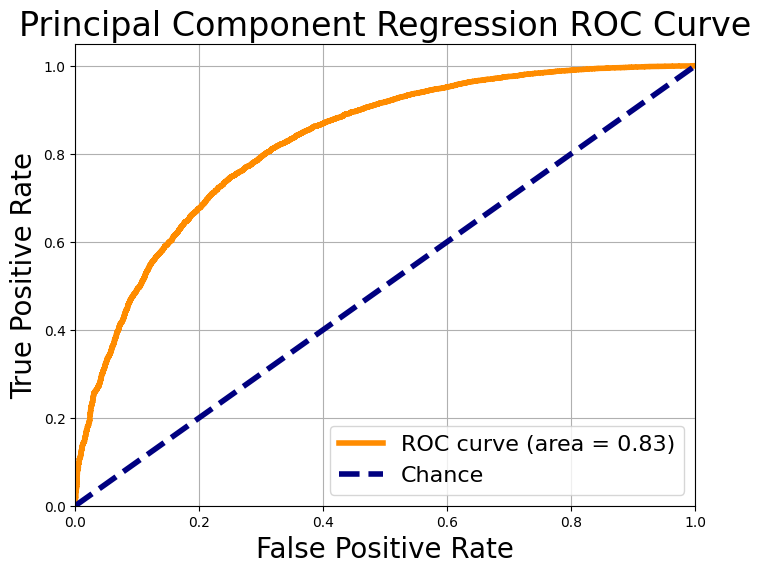

In [9]:
Y_hat = model_lr.decision_function(S_test)
fpr,tpr,_ = roc_curve(Y_test,Y_hat)
plt.figure(figsize=(8, 6))
roc_auc = roc_auc_score(Y_test,Y_hat)
plt.plot(fpr, tpr, color='darkorange', lw=4, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='Chance')

# Enhancements
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Principal Component Regression ROC Curve', fontsize=24)
plt.legend(loc="lower right",fontsize=16)
plt.grid(True)
plt.show()

# Logistic Regression Performance

We can see how much information we lost by using a linear model on the original features without dimensionality reduction. We use cross-validation with $L_2$ regularization to see the maximum performance we can possibly extract using any linear model. While deep-learning methods would likely be able to outperform these methods, from a scientific point of view it is critical that these parameters have a straightforward scientific interpretation, as we use them to develop stimulation procedures to modify behavior

In [10]:
model_full = LogisticRegressionCV(n_jobs=5,max_iter=10000)
model_full.fit(X_train,Y_train)
Y_hat = model_full.decision_function(X_test)


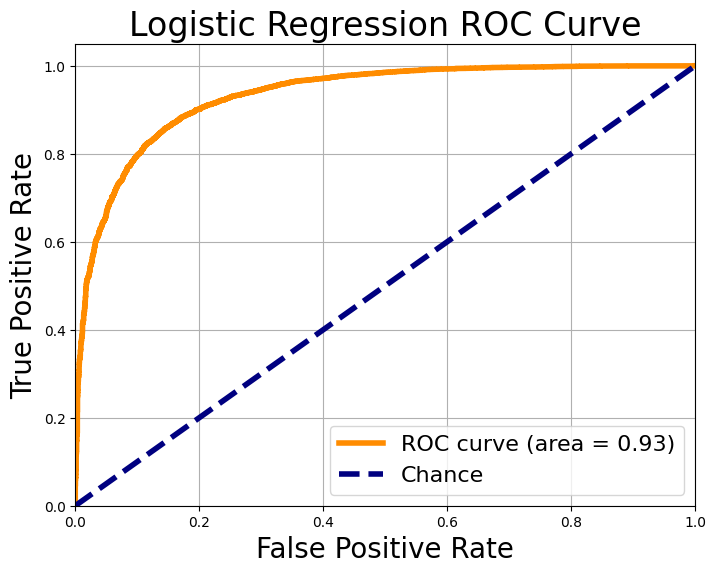

In [11]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(Y_test, Y_hat)
fpr, tpr, _ = roc_curve(Y_test, Y_hat)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=4, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='Chance')

# Enhancements
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Logistic Regression ROC Curve', fontsize=24)
plt.legend(loc="lower right",fontsize=16)
plt.grid(True)
plt.show()

Note that the predictive ability is far superior to Principal Component Regression. Any objective individual with extensive experience dealing with latent factor models will freely admit that generative models have severely degraded performance. An ROC of 0.93 is incredibe, especially when considering that these predictions are occuring in new mice.

## Our solution: modifying the maximum likelihood objective in probabilistic PCA

The previous section shows why often generative models are ignored, in spite of their nice scientific/theoretical properties (there are others I don't describe here). In my work that is in preparation, I show that the problem is not generative models themselves, instead the problem lies with maximum likelihood estimation which is almost ubiquitously used in statistics. The variance contained in electrophysiology is so large compared to the variance in the predictive label that unless the differences are absolutely blatant, the ML objective ignores the tiny dynamics relevant to the behavior of interest.

My objective fixes this by strongly upweighting a predictive loss attached to the likelihood. We can fit this objective via a clever variational lower bound on this ideal objective, allowing for us to use standard techniques used for variational autoencoders to learn the probabilistic PCA model. I know I'm being vague, but if you are very curious/impressed by the results I would be glad to send you a PDF almost ready for publication.

# Steps for our supervised PPCA model

### 1. Creating a PPCADropout Object
In Bystro (or similarly in scikit-learn), the first step is to create the PPCADropout instance. This model is identical functionality to PCA from scikit learn. Any training options go in the creation method.

### 2. Fit Model Using the `fit()` Method
Once you have your PPCADropout object, the next step is to fit the model given data. You do this by calling the `fit()` method on your PPCADropout object and passing in the data as covariates and labels. For example, `model_spca.fit(X,y)`. 

### 3. Analyzing the loadings
After the `fit()` method has been applied, you get a model with loadings (and predictive coefficients in a regression task) stored as model attributes

### Putting It All Together
The process with PPCADropout is straightforward:

- **Create**: You start by creating a PPCADropout object that will learn your model
- **Fit**: You then fit the model given data 
- **Analyze**: Analyze the model parameters


*Note: we will have a convergence issue with the number of iterations we use here (3000), but this is ok, because we are only using the intercept, rather than fitted coefficients*

In [12]:
model_spca = PPCADropout(n_components=5,n_supervised=1,delta=10.,mu=10.0,
                         training_options={"learning_rate":5e-3,'batch_size':10000})
model_spca.fit(X_train.astype(np.float32),Y_train.astype(np.float32))

/Users/alexkotlar/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:02<00:00, 24.53it/s]


PPCApt(n_components=5)

## Estimate factors on the test data

In [13]:
S_test = model_spca.transform(X_test)

## Analyze predictive performance

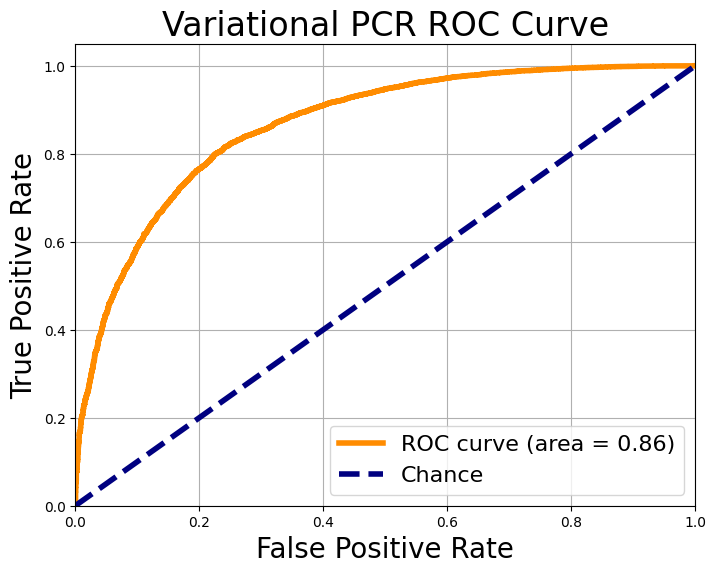

In [14]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(Y_test, S_test[:,0])
fpr, tpr, _ = roc_curve(Y_test, S_test[:,0])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=4, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--', label='Chance')

# Enhancements
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Variational PCR ROC Curve', fontsize=24)
plt.legend(loc="lower right",fontsize=16)
plt.grid(True)
plt.show()

Note that we almost have recovered the predictive performance of a linear model, while using a generative model! This approach made it so that I could discover a network relevant to social behavior and get a PhD (more accurately, a rougher/finicky version as opposed to the one we're presenting here).

# Now let's look at the Predictive Coefficients

At this point you might be wondering what's so great about the generative model if we can get better performance from a linear model? Here is where we highlight why generative models are so nice. We plot the coefficients of the linear model. We plot the coefficients for each brain region over the frequency space, there are 11 regions and 56 frequencies so there are 11 plots of 56 coefficients each.

/var/folders/hp/6z1jrcn57q751djqg4dt_9b80000gq/T/ipykernel_37408/2848566423.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')  # 'tab10' provides 10 distinct colors


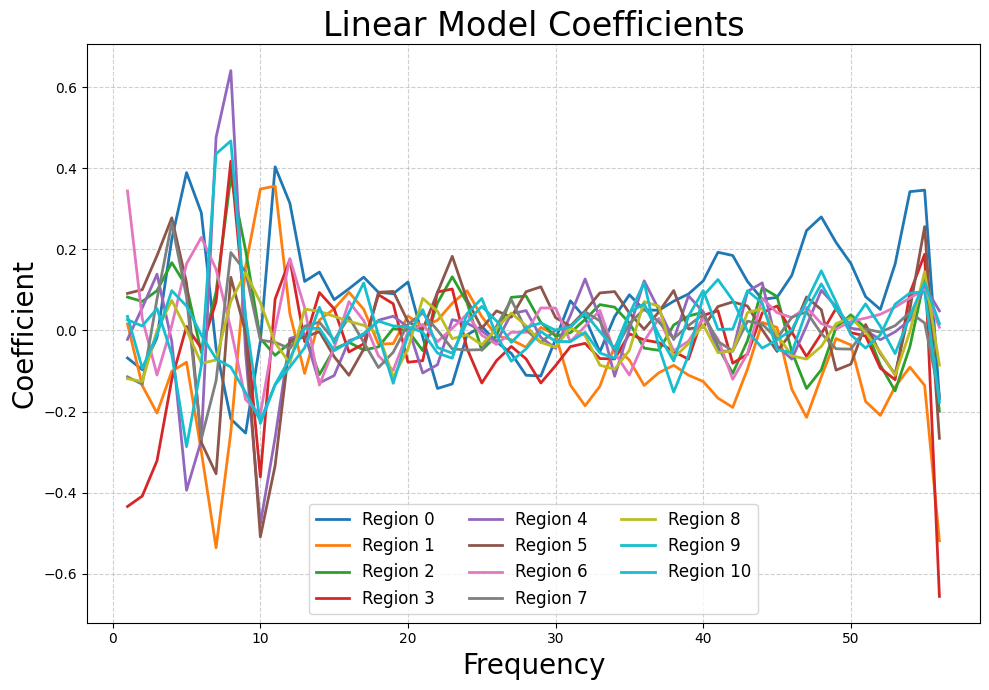

In [15]:
from matplotlib.cm import get_cmap

cmap = get_cmap('tab10')  # 'tab10' provides 10 distinct colors

plt.figure(figsize=(10, 7))
for i in range(11):
    plt.plot(1 + np.arange(56), model_full.coef_[0, i*56:56*(i+1)],
             label=f'Region {int(i)}', color=cmap(i), lw=2)

# Enhancements
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Coefficient', fontsize=20)
plt.title('Linear Model Coefficients', fontsize=24)
plt.legend(loc='lower center', ncol=3, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

This looks like a jumbled mess, with wild oscillations in whether power in a specific region is positively or negatively correlated with stressful condtions. To emphasize that fact, we plot the coefficients in the first brain region. While at the very lowest frequencies (1-7) Hz, there can be large differences, by the time we get to beta (20-50 Hz) these changes should be very gradual. Instead, what we see is jagged relationships between the power and behavior. We might assume that we could suppress stress by positively stimulating at the very lowest frequencies but above 7 Hz it's impossible to make any sort of valid scientific conclusions. No stimulation procedure should be sensitive to 43 vs 46 Hz signals. 

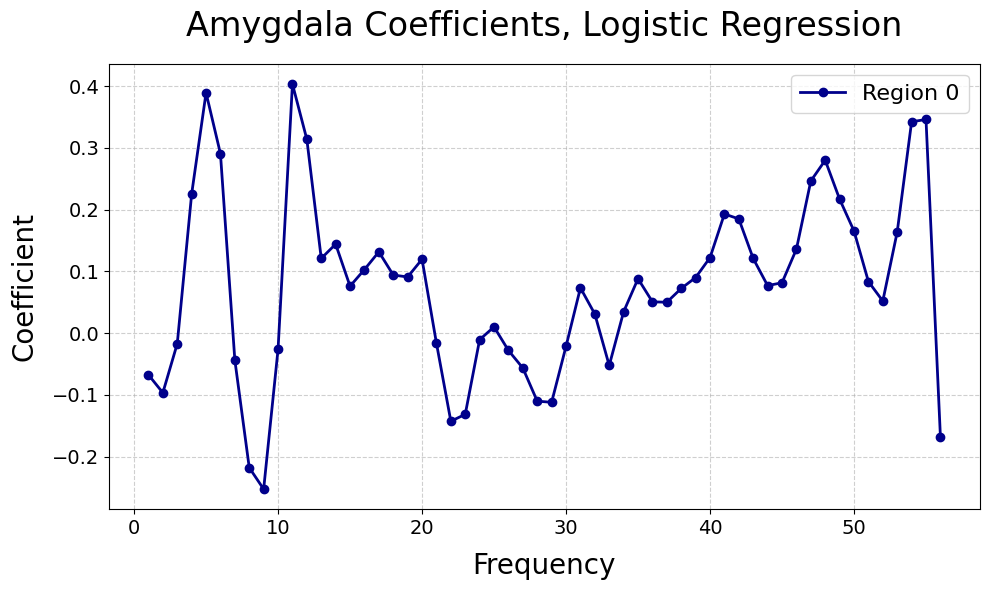

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(1 + np.arange(56), model_full.coef_[0, 0*56:56*(1)], 
         label='Region 0', color='darkblue', linestyle='-', linewidth=2, marker='o', markersize=6)

# Enhancements
plt.xlabel('Frequency', fontsize=20, labelpad=10)
plt.ylabel('Coefficient', fontsize=20, labelpad=10)
plt.title('Amygdala Coefficients, Logistic Regression', fontsize=24, pad=20)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()

### Now our generative model

We now plot our generative model coefficients and they look amazing! All of the regions have smooth curves/trajectories as we would expect. We can see clear regional differences (we would naturally expect different brain regions to respond differently to stress, but looking at these coefficients it's quite natural to decide how to stimulate 

/var/folders/hp/6z1jrcn57q751djqg4dt_9b80000gq/T/ipykernel_37408/3515980219.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')  # 'tab10' provides 10 distinct colors


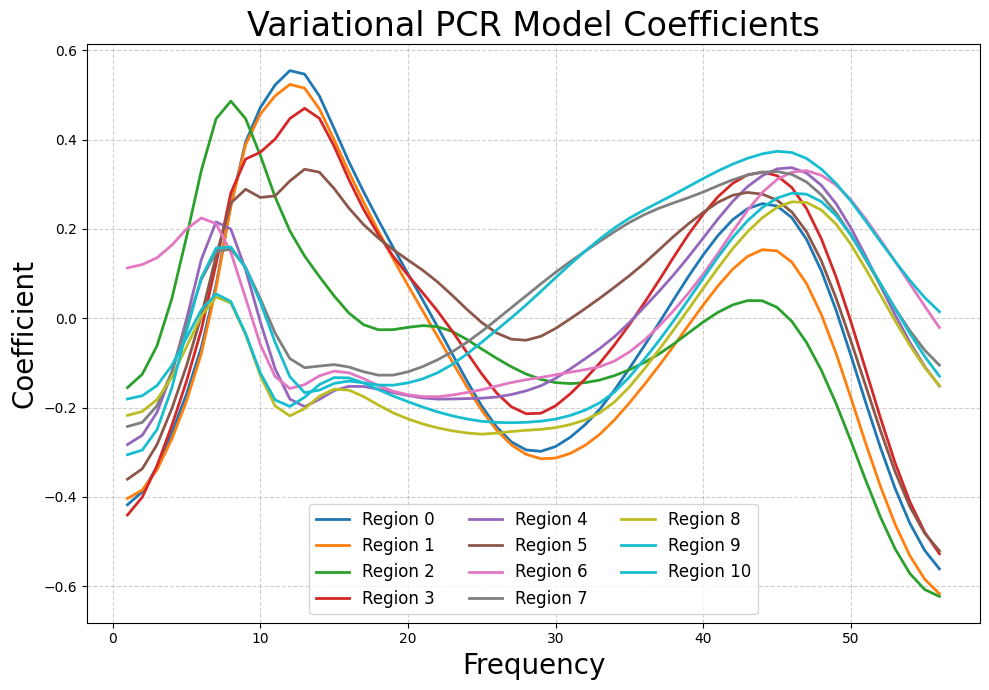

In [17]:
cmap = get_cmap('tab10')  # 'tab10' provides 10 distinct colors

plt.figure(figsize=(10, 7))
for i in range(11):
    plt.plot(1 + np.arange(56), model_spca.W_[0,i*56:56*(i+1)],
             label=f'Region {int(i)}', color=cmap(i), lw=2)

# Enhancements
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Coefficient', fontsize=20)
plt.title('Variational PCR Model Coefficients', fontsize=24)
plt.legend(loc='lower center', ncol=3, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In other words, linear models with regularization assume sparsity **in the measured covariates** whereas our generative model assumes sparsity **in dimensionality**. The covariates we discover change together as a network, rather than being viewed as independent according to a standard linear model with penalization on the coefficients. And just to drive the point home, we plot the coefficients associated with the first brain region again.

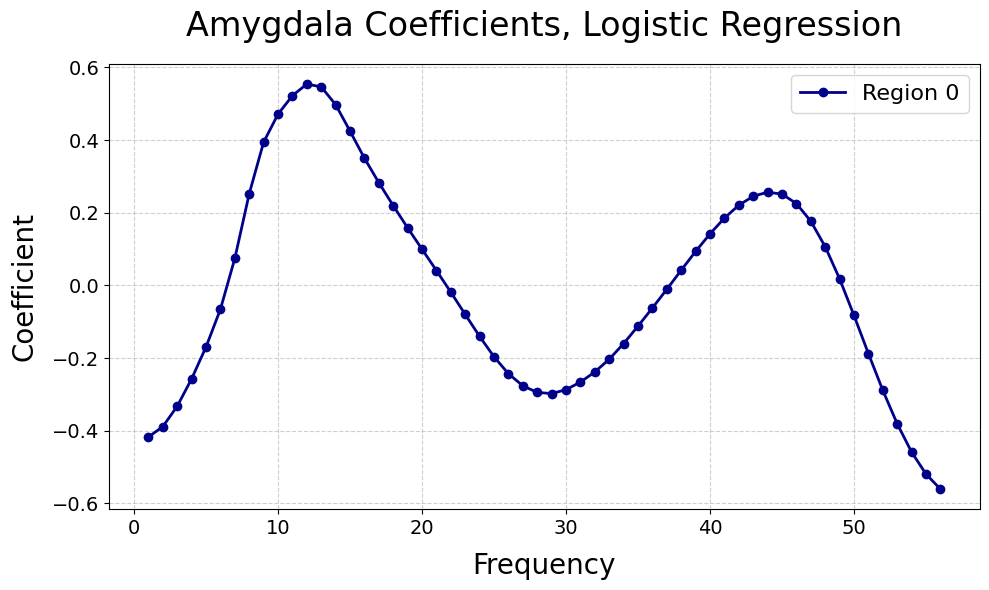

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(1 + np.arange(56), model_spca.W_[0,0*56:56*(1)],
         label='Region 0', color='darkblue', linestyle='-', linewidth=2, marker='o', markersize=6)

# Enhancements
plt.xlabel('Frequency', fontsize=20, labelpad=10)
plt.ylabel('Coefficient', fontsize=20, labelpad=10)
plt.title('Amygdala Coefficients, Logistic Regression', fontsize=24, pad=20)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()

# Conclusions

Our model gives all the benefits of probabilistic PCA, PCR, and logistic regression but better. We get more interpretable loadings, a generative model, and the ability to handle missing covariates.